#### Get all the character anchor list

In [5]:
import requests
from bs4 import BeautifulSoup as bs


In [6]:
base_url = "https://genshin.gg"
r = requests.get(base_url)
soup = bs(r.text , 'html.parser')
d_charlist = soup.find('div', attrs={"class":"character-list"})
a_charlist = [c['href'] for c in d_charlist.find_all('a' , attrs={'class':"character-portrait"})]

# remove amber and hydro traveler outliers (NO TEAMS LOL)
a_charlist.remove("/characters/amber/")
a_charlist.remove('/characters/traveler(hydro)/')


print(a_charlist)

['/characters/albedo/', '/characters/alhaitham/', '/characters/aloy/', '/characters/ayaka/', '/characters/ayato/', '/characters/baizhu/', '/characters/childe/', '/characters/chiori/', '/characters/cyno/', '/characters/dehya/', '/characters/diluc/', '/characters/eula/', '/characters/furina/', '/characters/ganyu/', '/characters/hutao/', '/characters/itto/', '/characters/jean/', '/characters/kazuha/', '/characters/keqing/', '/characters/klee/', '/characters/kokomi/', '/characters/lyney/', '/characters/mona/', '/characters/nahida/', '/characters/navia/', '/characters/neuvillette/', '/characters/nilou/', '/characters/qiqi/', '/characters/raiden/', '/characters/shenhe/', '/characters/tighnari/', '/characters/traveler(anemo)/', '/characters/traveler(dendro)/', '/characters/traveler(electro)/', '/characters/traveler(geo)/', '/characters/venti/', '/characters/wanderer/', '/characters/wriothesley/', '/characters/xianyun/', '/characters/xiao/', '/characters/yaemiko/', '/characters/yelan/', '/char

create the list of characters and anchor to name fun def

In [7]:
charlist = [c.split('/characters/')[1][:-1] for c in a_charlist]
print(charlist)

def atot(anchor):
    return anchor.split('/characters/')[1][:-1]

['albedo', 'alhaitham', 'aloy', 'ayaka', 'ayato', 'baizhu', 'childe', 'chiori', 'cyno', 'dehya', 'diluc', 'eula', 'furina', 'ganyu', 'hutao', 'itto', 'jean', 'kazuha', 'keqing', 'klee', 'kokomi', 'lyney', 'mona', 'nahida', 'navia', 'neuvillette', 'nilou', 'qiqi', 'raiden', 'shenhe', 'tighnari', 'traveler(anemo)', 'traveler(dendro)', 'traveler(electro)', 'traveler(geo)', 'venti', 'wanderer', 'wriothesley', 'xianyun', 'xiao', 'yaemiko', 'yelan', 'yoimiya', 'zhongli', 'barbara', 'beidou', 'bennett', 'candace', 'charlotte', 'chevreuse', 'chongyun', 'collei', 'diona', 'dori', 'faruzan', 'fischl', 'freminet', 'gaming', 'gorou', 'heizou', 'kaeya', 'kaveh', 'kirara', 'kukishinobu', 'layla', 'lisa', 'lynette', 'mika', 'ningguang', 'noelle', 'razor', 'rosaria', 'sara', 'sayu', 'sucrose', 'thoma', 'xiangling', 'xingqiu', 'xinyan', 'yanfei', 'yaoyao', 'yunjin']


### Come organizzare gli oggetti dei teams
- Il database e' un oggetto che contiene personaggi
- Ogni personaggio e' un oggetto con nome del personaggio
- Ogni personaggio ha un campo teams che e' una lista 
- Ogni lista contiene a sua volta una lista di personaggi con cui e' associato il personaggio come teams

In [6]:
db = {} 
for a_char in a_charlist:
  character = atot(a_char)
  db[character] = []
  r = requests.get(base_url + a_char)
  s = bs(r.text , 'html.parser')
  d_teams = s.find_all('div', attrs={'class':'character-team-characters'})
  for d_team in d_teams :
    alist = d_team.find_all('a' , attrs={'class':'character-portrait'})
    alist = [atot(x['href']) for x in alist]
    for c in alist:
      if (c not in db[character]) and (c != character):
        db[character].append(c) 

In [7]:
# save db as a json file
import json
with open("teams_database.json", 'w') as file:
  json.dump(db , file, indent=4)


## Use saved db json file as db

In [16]:
import json
with open("teams_database.json" , 'r') as file:
  db = json.load(file)

### Download character images


In [28]:
char_icon_list = [c['src'] for c in d_charlist.find_all('img' , attrs={'class':"character-icon"})]

char_icon_list.remove('https://rerollcdn.com/GENSHIN/Characters/1/Amber.png')
char_icon_list.remove('https://rerollcdn.com/GENSHIN/Characters/1/Traveler (Hydro).png')

import shutil
def download_image(url, filename):
    # Send an HTTP request to the URL
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        # Open a local file with the given filename in binary write mode
        with open(filename, 'wb') as file:
            # Copy the image content from the HTTP response to the local file
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, file)
        print(f"Image downloaded successfully as {filename}")
    else:
        print("Failed to download image")


for url in char_icon_list : 
    filename = "icons/" + url.split('https://rerollcdn.com/GENSHIN/Characters/1/')[1].split('.png')[0].replace(" ", "").lower() + '.png'
    download_image(url, filename)


Image downloaded successfully as icons/albedo.png
Image downloaded successfully as icons/alhaitham.png
Image downloaded successfully as icons/aloy.png
Image downloaded successfully as icons/ayaka.png
Image downloaded successfully as icons/ayato.png
Image downloaded successfully as icons/baizhu.png
Image downloaded successfully as icons/childe.png
Image downloaded successfully as icons/chiori.png
Image downloaded successfully as icons/cyno.png
Image downloaded successfully as icons/dehya.png
Image downloaded successfully as icons/diluc.png
Image downloaded successfully as icons/eula.png
Image downloaded successfully as icons/furina.png
Image downloaded successfully as icons/ganyu.png
Image downloaded successfully as icons/hutao.png
Image downloaded successfully as icons/itto.png
Image downloaded successfully as icons/jean.png
Image downloaded successfully as icons/kazuha.png
Image downloaded successfully as icons/keqing.png
Image downloaded successfully as icons/klee.png
Image downloade

### Convert db to a graph using networkX

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


## Funzione per aggiungere immagini come nodi 

In [50]:
# non ci sono problemi con l'odrine se entrambe le volte che aggiungo nodi al grafo (per prendere le posizioni e per diseganre il grafo)
def add_image_node(graph, node, image_path, pos):
    img = plt.imread(image_path) #leggi immagini
    imagebox = OffsetImage(img, zoom=0.15) # ridimensiona 
    ab = AnnotationBbox(imagebox, pos, frameon=False) # attacca in posizione pos
    plt.gca().add_artist(ab)
    graph.add_node(node)

In [59]:
## get edge weight using the times a character is in another char team
## this is the number of times a characters is recommended to from another character page
times_used = {}
for char in charlist:
  n = 0
  for target in charlist:
    if char in db[target] : n = n+1
  times_used[char] = n 

print(times_used)

{'albedo': 7, 'alhaitham': 10, 'aloy': 1, 'ayaka': 14, 'ayato': 3, 'baizhu': 2, 'childe': 8, 'chiori': 0, 'cyno': 4, 'dehya': 1, 'diluc': 1, 'eula': 6, 'furina': 6, 'ganyu': 8, 'hutao': 10, 'itto': 4, 'jean': 3, 'kazuha': 37, 'keqing': 6, 'klee': 0, 'kokomi': 22, 'lyney': 1, 'mona': 8, 'nahida': 23, 'navia': 1, 'neuvillette': 0, 'nilou': 12, 'qiqi': 0, 'raiden': 9, 'shenhe': 11, 'tighnari': 1, 'traveler(anemo)': 0, 'traveler(dendro)': 1, 'traveler(electro)': 0, 'traveler(geo)': 0, 'venti': 9, 'wanderer': 2, 'wriothesley': 1, 'xianyun': 3, 'xiao': 10, 'yaemiko': 11, 'yelan': 9, 'yoimiya': 5, 'zhongli': 31, 'barbara': 1, 'beidou': 9, 'bennett': 44, 'candace': 0, 'charlotte': 0, 'chevreuse': 0, 'chongyun': 1, 'collei': 3, 'diona': 6, 'dori': 0, 'faruzan': 9, 'fischl': 35, 'freminet': 0, 'gaming': 0, 'gorou': 5, 'heizou': 0, 'kaeya': 2, 'kaveh': 0, 'kirara': 0, 'kukishinobu': 10, 'layla': 0, 'lisa': 0, 'lynette': 0, 'mika': 4, 'ningguang': 0, 'noelle': 0, 'razor': 0, 'rosaria': 11, 'sara':

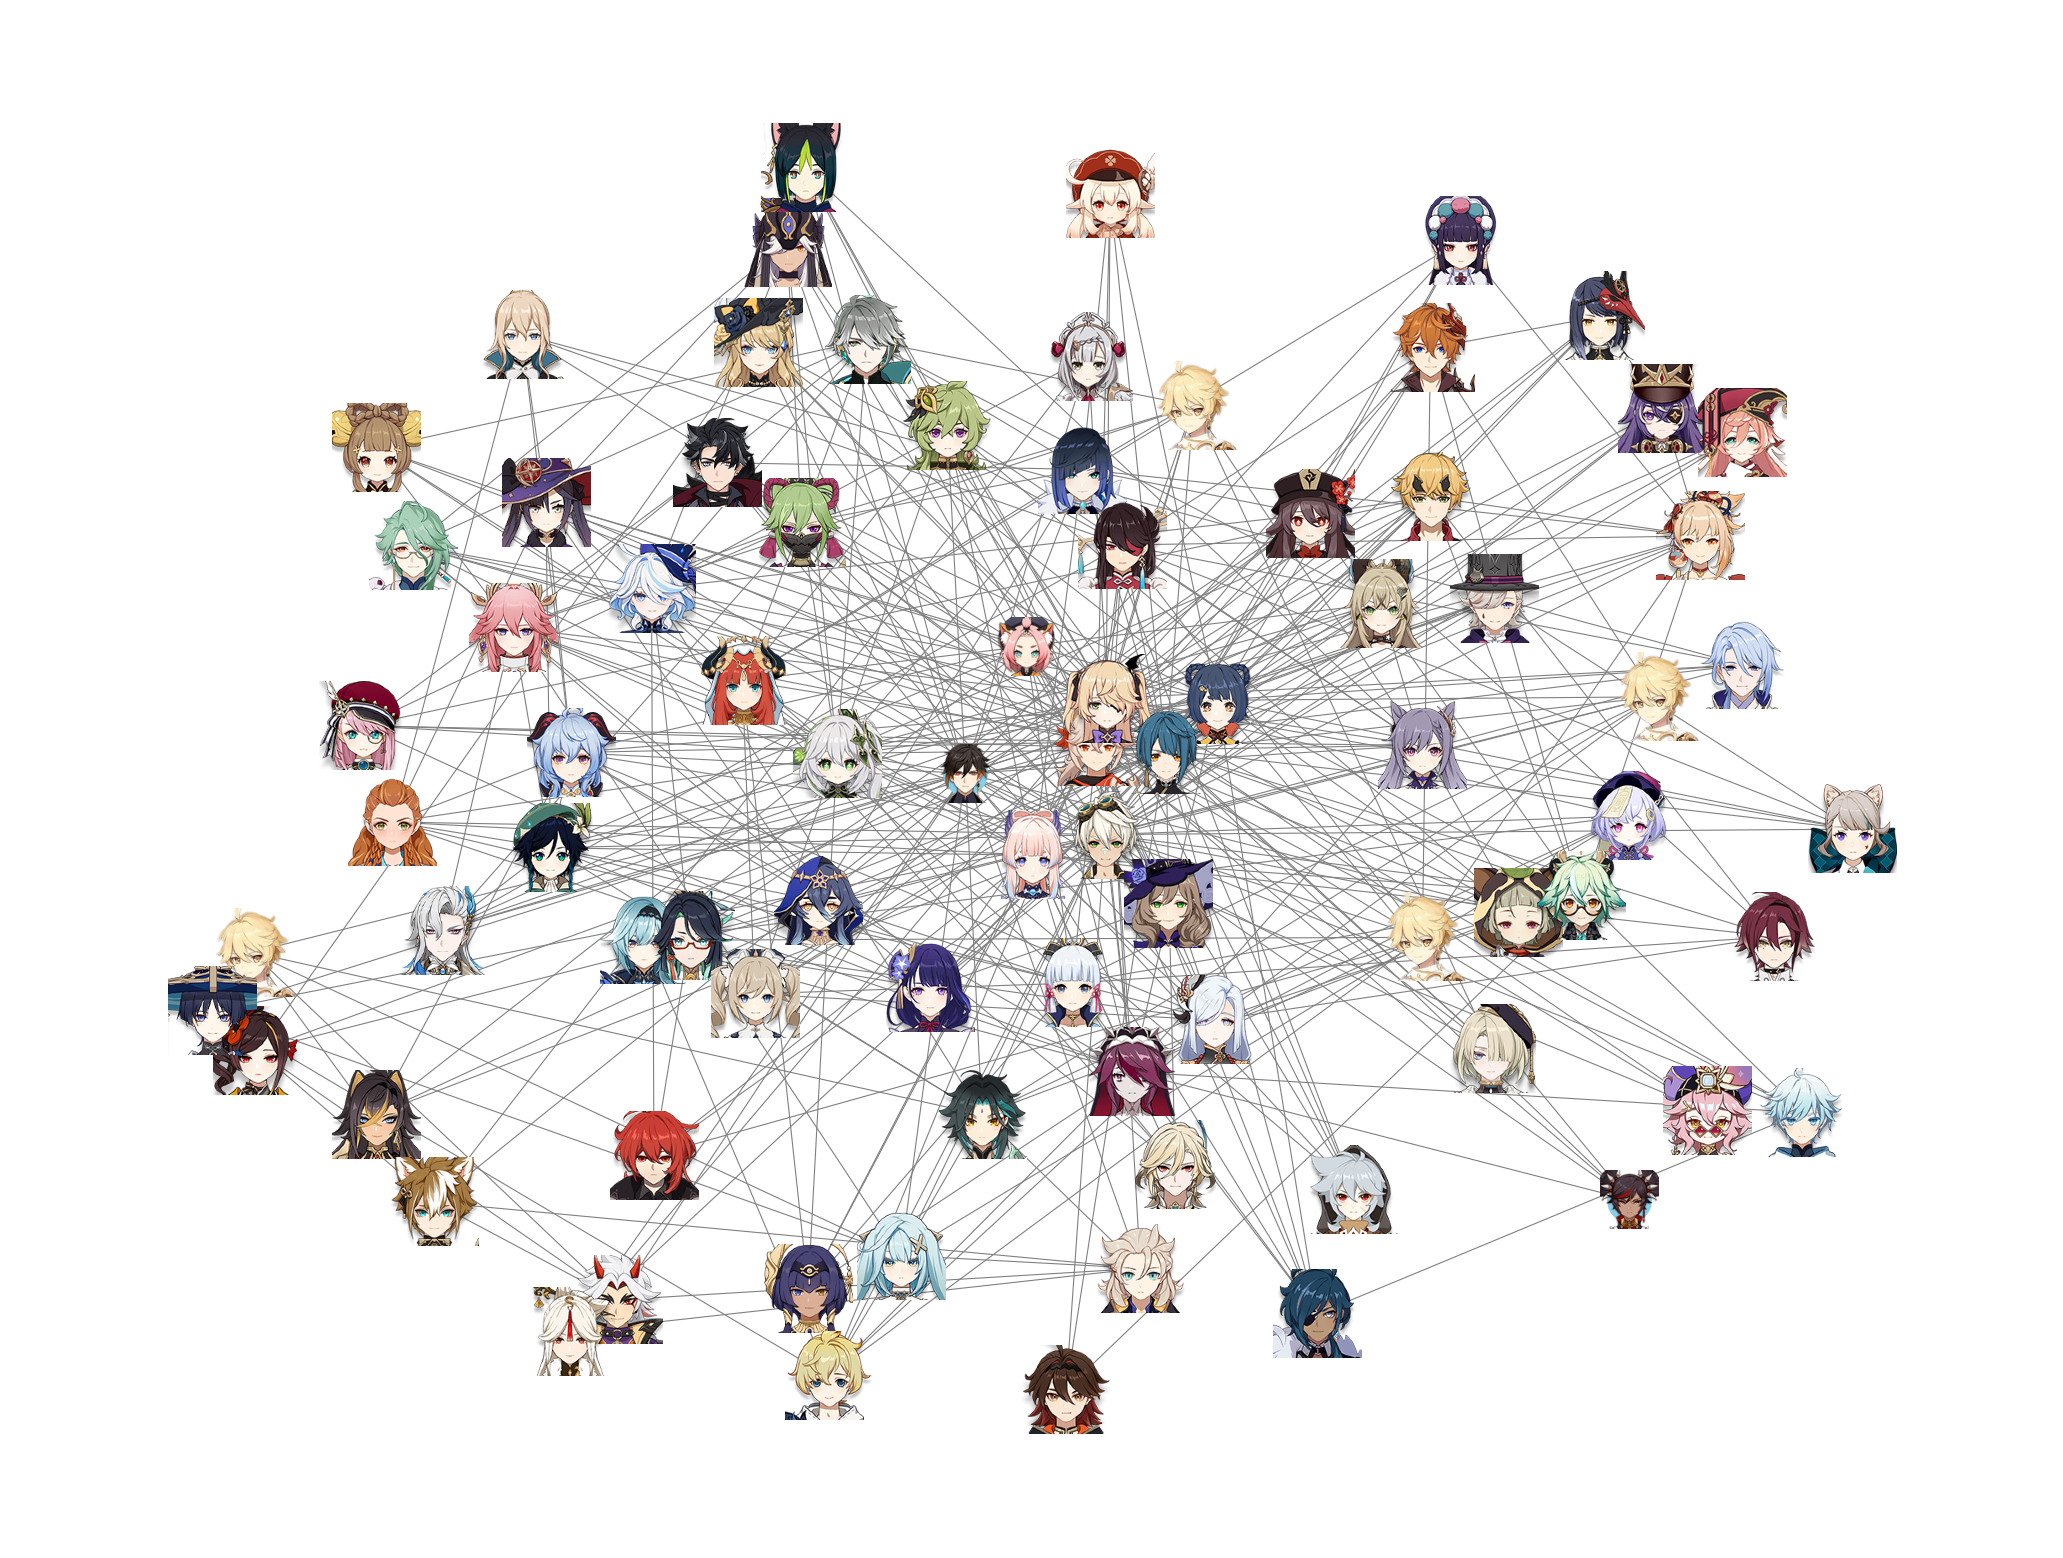

In [67]:
g = nx.Graph()
plt.figure(dpi=400)
#add all nodes and edges, get positions, remove nodes, add them back with images
g.add_nodes_from(charlist)
for c1 in charlist: 
  for c2 in db[c1] : 
    g.add_edge(c1 , c2) # add weight=times_used[c1] for wheighted graph

#prendo le posizioni con lo spltring_layout dei nodi
pos = nx.spring_layout(g, k=1.2) ## set to 2 if weighted graph for better visual
g.clear()

for char in charlist:
  add_image_node(g , char , "icons/"+char+".png" , pos[char])



for c1 in charlist: 
  for c2 in db[c1] : 
    g.add_edge(c1 , c2)


nx.draw(g, pos=pos ,with_labels=False , node_color='skyblue', node_size=50, width=0.2, font_size=8, edge_color="gray")

nx.write_gexf(g , "genshingraph.gexf")

# plt.axis('off')